# Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from lightgbm.callback import early_stopping,log_evaluation
from lightgbm import LGBMRegressor
sns.set_theme()

# 1. Data preprocessing

### 1.1 Load dataset

In [2]:
sample_supmission=pd.read_csv('sample_submission_V2.csv')
train=pd.read_csv('train_V2.csv')
test=pd.read_csv('test_V2.csv')

In [3]:
train

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.000,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.040,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.000,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.000,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.000,0,0,49.75,2,0,0.1875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446961,afff7f652dbc10,d238e426f50de7,18492834ce5635,0,0,0.00,0,0,0,74,...,0,1292.0000,0,0.000,0,0,1019.00,3,1507,0.1786
4446962,f4197cf374e6c0,408cdb5c46b2ac,ee854b837376d9,0,1,44.15,0,0,0,69,...,0,0.0000,0,0.000,0,0,81.70,6,0,0.2935
4446963,e1948b1295c88a,e26ac84bdf7cef,6d0cd12784f1ab,0,0,59.06,0,0,0,66,...,0,0.0000,0,2.184,0,0,788.70,4,0,0.4815
4446964,cc032cdd73b7ac,c2223f35411394,c9c701d0ad758a,0,4,180.40,1,1,2,11,...,2,0.0000,0,0.000,0,0,2748.00,8,0,0.8000


In [4]:
# infor data
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

### 1.2 Data cleaning
+ Resolve missing value
+ Identify and eliminate noise data. I will accept noisy data
+ Resolve conflicting data. In general, the columns do not have any conflicts

In [5]:
# Number of NA value
print('Number of NA value:',train.isna().sum().sum())

Number of NA value: 1


In [6]:
# Drop NA
train=train.dropna()

### 1.3 Data integration
+ Select only required data for the data mining process
+ Eliminate redundant and duplicate data

Dropping the Id column as it will be of no use

In [7]:
# drop ID column
train.drop('Id',axis=1,inplace=True)

C:\Users\Admin\AppData\Local\Temp\ipykernel_5200\636207657.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop('Id',axis=1,inplace=True)


In [8]:
# Count duplicated
print("Number of duplicated:",train.duplicated().sum())

Number of duplicated: 0


### 1.4 Data reduction
+ Reducing Dataset Memory
+ Convert type

In [9]:
print("the size of the data before reduction",train.memory_usage(index=True).sum()/(1024*1024), "MB")

the size of the data before reduction 983.9018630981445 MB


Because pubg matches with more than 80 players are valid, I will remove matches with less than 80 players.

In [10]:
sub_mask=train['matchId'].value_counts()>=80
train=train.set_index('matchId')[sub_mask].reset_index()

C:\Users\Admin\AppData\Local\Temp\ipykernel_5200\2527598430.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train=train.set_index('matchId')[sub_mask].reset_index()


matchType has many types I would like to change to number of players per team instead of fpp or tpp modes. *solo* = 1, *dou* = 2, *squad* = 4

In [11]:
# Count number of unique values
train['matchType'].value_counts()

matchType
squad-fpp           1743028
duo-fpp              988780
squad                622194
solo-fpp             531639
duo                  309952
solo                 170862
crashfpp               5560
flaretpp               2232
normal-squad-fpp        456
flarefpp                455
crashtpp                173
normal-squad             99
normal-duo-fpp           98
Name: count, dtype: int64

In [12]:
# convert from object to interger 
train['matchType']=train['matchType'].apply(lambda x: 1 if ('solo' in x) else 2 if ('duo' in x) or ('crash' in x) else 4 )
train['matchType'].value_counts()

matchType
4    2368464
2    1304563
1     702501
Name: count, dtype: int64

+ Because the data types of the columns are not consistent, I will reduce them to make the calculation faster

In [13]:
# reduce data
for col in train:
    if train[col].dtype=='float64':
        train[col]= pd.to_numeric(train[col], downcast= 'float')
    if train[col].dtype=='int64':
        train[col]= pd.to_numeric(train[col], downcast= 'integer')

In [14]:
# Memory usages in Bytes
print("the size of the data after reduction",train.memory_usage(index=True).sum()/(1024*1024), "MB")

the size of the data after reduction 271.2339897155762 MB


After data reduction, the data has been reduced by more than 600mb, making data exploration faster

# 2. Exploratory Data Analysis

### 2.1 Decription data

In [15]:
# Description data
df_description=train.describe().drop('count').T
df_description

,mean,std,min,25%,50%,75%,max
assists,0.229377,0.571144,0.0,0.0,0.000000,0.0000,12.0
boosts,1.104663,1.713482,0.0,0.0,0.000000,2.0000,33.0
damageDealt,129.282471,165.573929,0.0,0.0,83.849998,185.0000,4889.0
DBNOs,0.655855,1.125018,0.0,0.0,0.000000,1.0000,32.0
headshotKills,0.223885,0.586272,0.0,0.0,0.000000,0.0000,46.0
heals,1.363498,2.670475,0.0,0.0,0.000000,2.0000,80.0
killPlace,47.926222,27.449382,1.0,24.0,48.000000,72.0000,101.0
killPoints,504.357494,628.334971,0.0,0.0,0.000000,1174.0000,2170.0
kills,0.913337,1.502483,0.0,0.0,0.000000,1.0000,53.0
killStreaks,0.542794,0.708505,0.0,0.0,0.000000,1.0000,16.0


+ Mean: The average scores of the variables are quite diverse.
+ Std: Standard deviation indicates the variability of variables. Variables with larger standard deviations from the mean have strong fluctuations in the data. For example, "rideDistance" and "swimDistance" have very large standard deviations, possibly due to some samples having outliers.
+ Percentiles (Percent - 25%, 50%, 75%): Percentiles indicate the distribution of data within each variable.

Looking at the description table, most of the columns have data distributed completely concentrated on the left side, so the charts are similar to each other, so we will take one column as "damageDealt" as a representative and analyze further columns for example columns "walkDistance", "rankPoints" 

### 2.2 correlation between 'damageDealt' and "winPlacePerc"

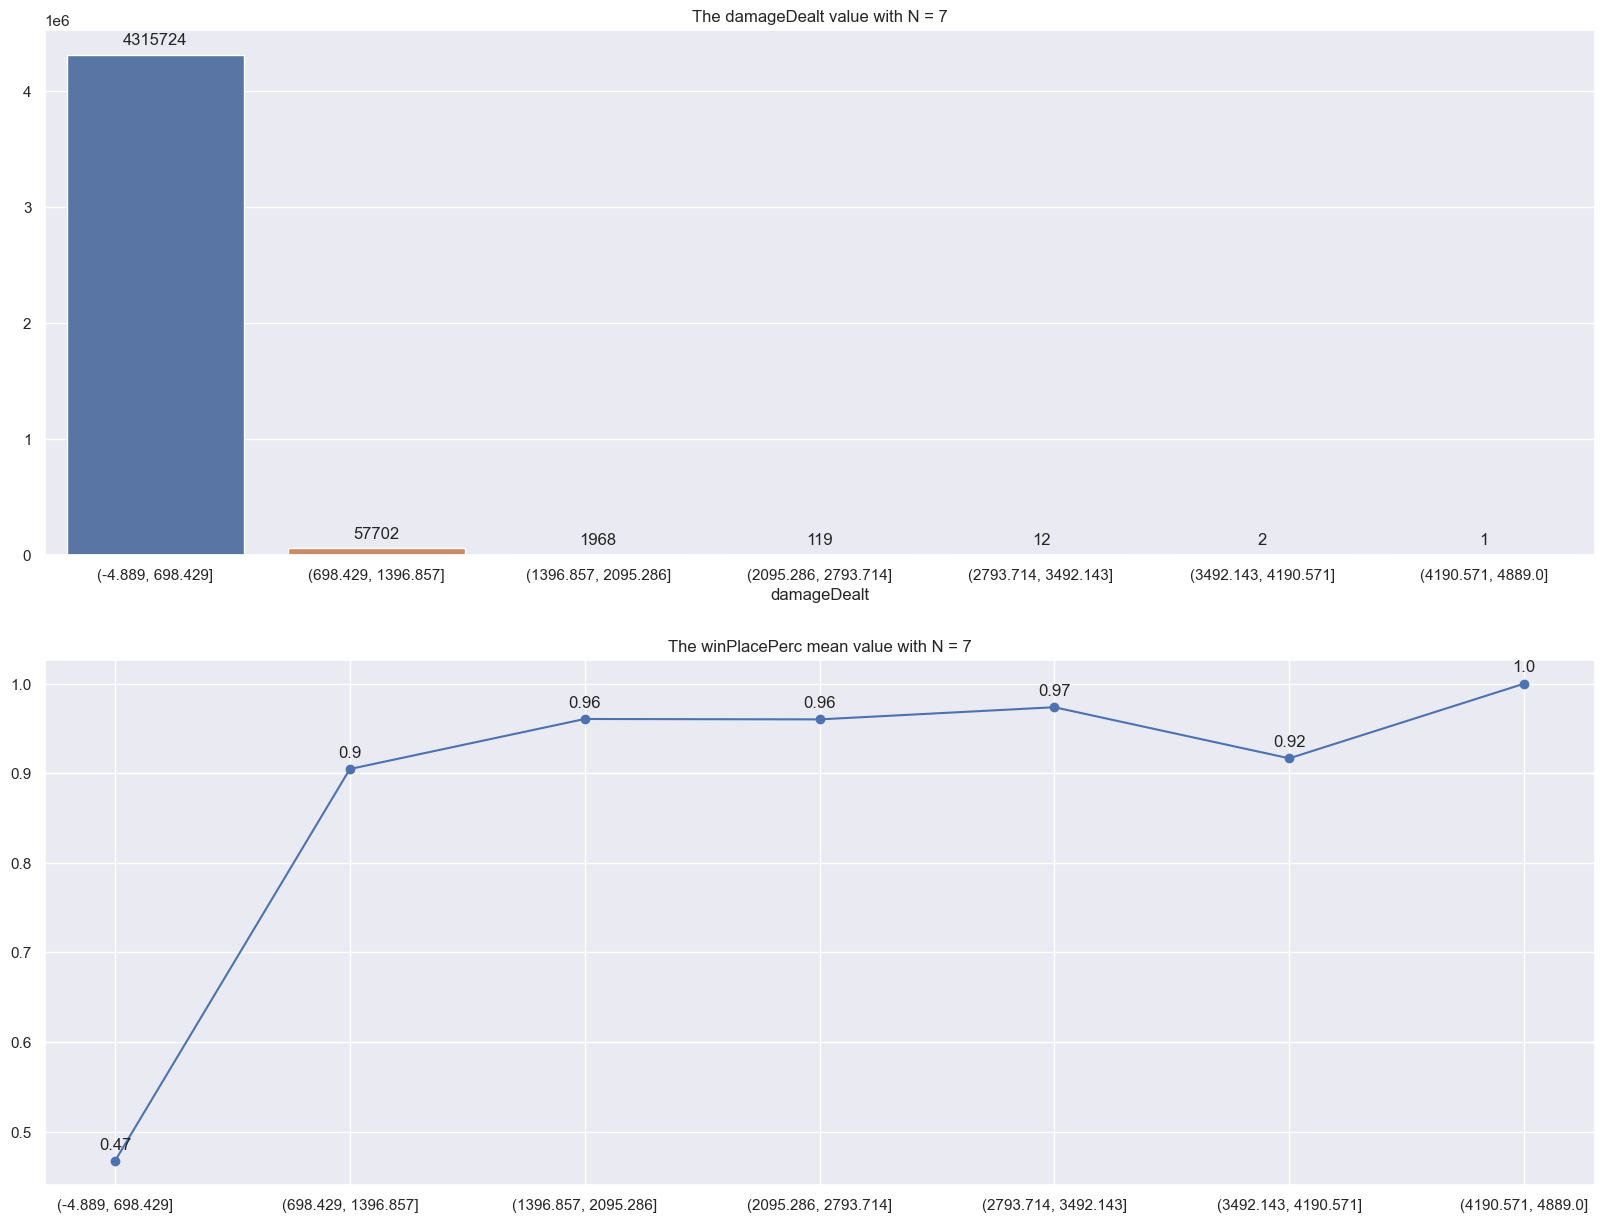

In [16]:
train1=train.copy()
# binning equal-widtd 
train1['damageDealt']=pd.cut(train1['damageDealt'], bins=7)
damageDealt_binning_10 = train1['damageDealt'].value_counts().sort_index()
winPlacePerc_binning=train1.groupby('damageDealt')['winPlacePerc'].mean().fillna(0)

# plot
plt.figure(figsize=(20,15))
plt.subplot(2,1,1)
sns.barplot(x=damageDealt_binning_10.index,y=damageDealt_binning_10.values)
for i, v in enumerate(damageDealt_binning_10):
    plt.text(i, v + 60000, str(v), ha='center', va='bottom')
plt.title("The damageDealt value with N = 7")

plt.subplot(2,1,2)
plt.plot(range(winPlacePerc_binning.count()),winPlacePerc_binning.values, marker='o', linestyle='-')
for i, v in enumerate(winPlacePerc_binning):
    plt.text(i, v + 0.01, str(round(v,2)), ha='center', va='bottom')
plt.title("The winPlacePerc mean value with N = 7")
plt.xticks(range(winPlacePerc_binning.count()),winPlacePerc_binning.index);

Looking at the two charts above, we can see that the greater the amount of damage caused, the higher the rate of reaching top 1. similar to the columns not mentioned above, the histogram chart of those columns will be similar to the chart 'The damageDealt value with N = 10' in that it will focus almost all on the left

### 2.3 correlation between 'killPlace' and "winPlacePerc"

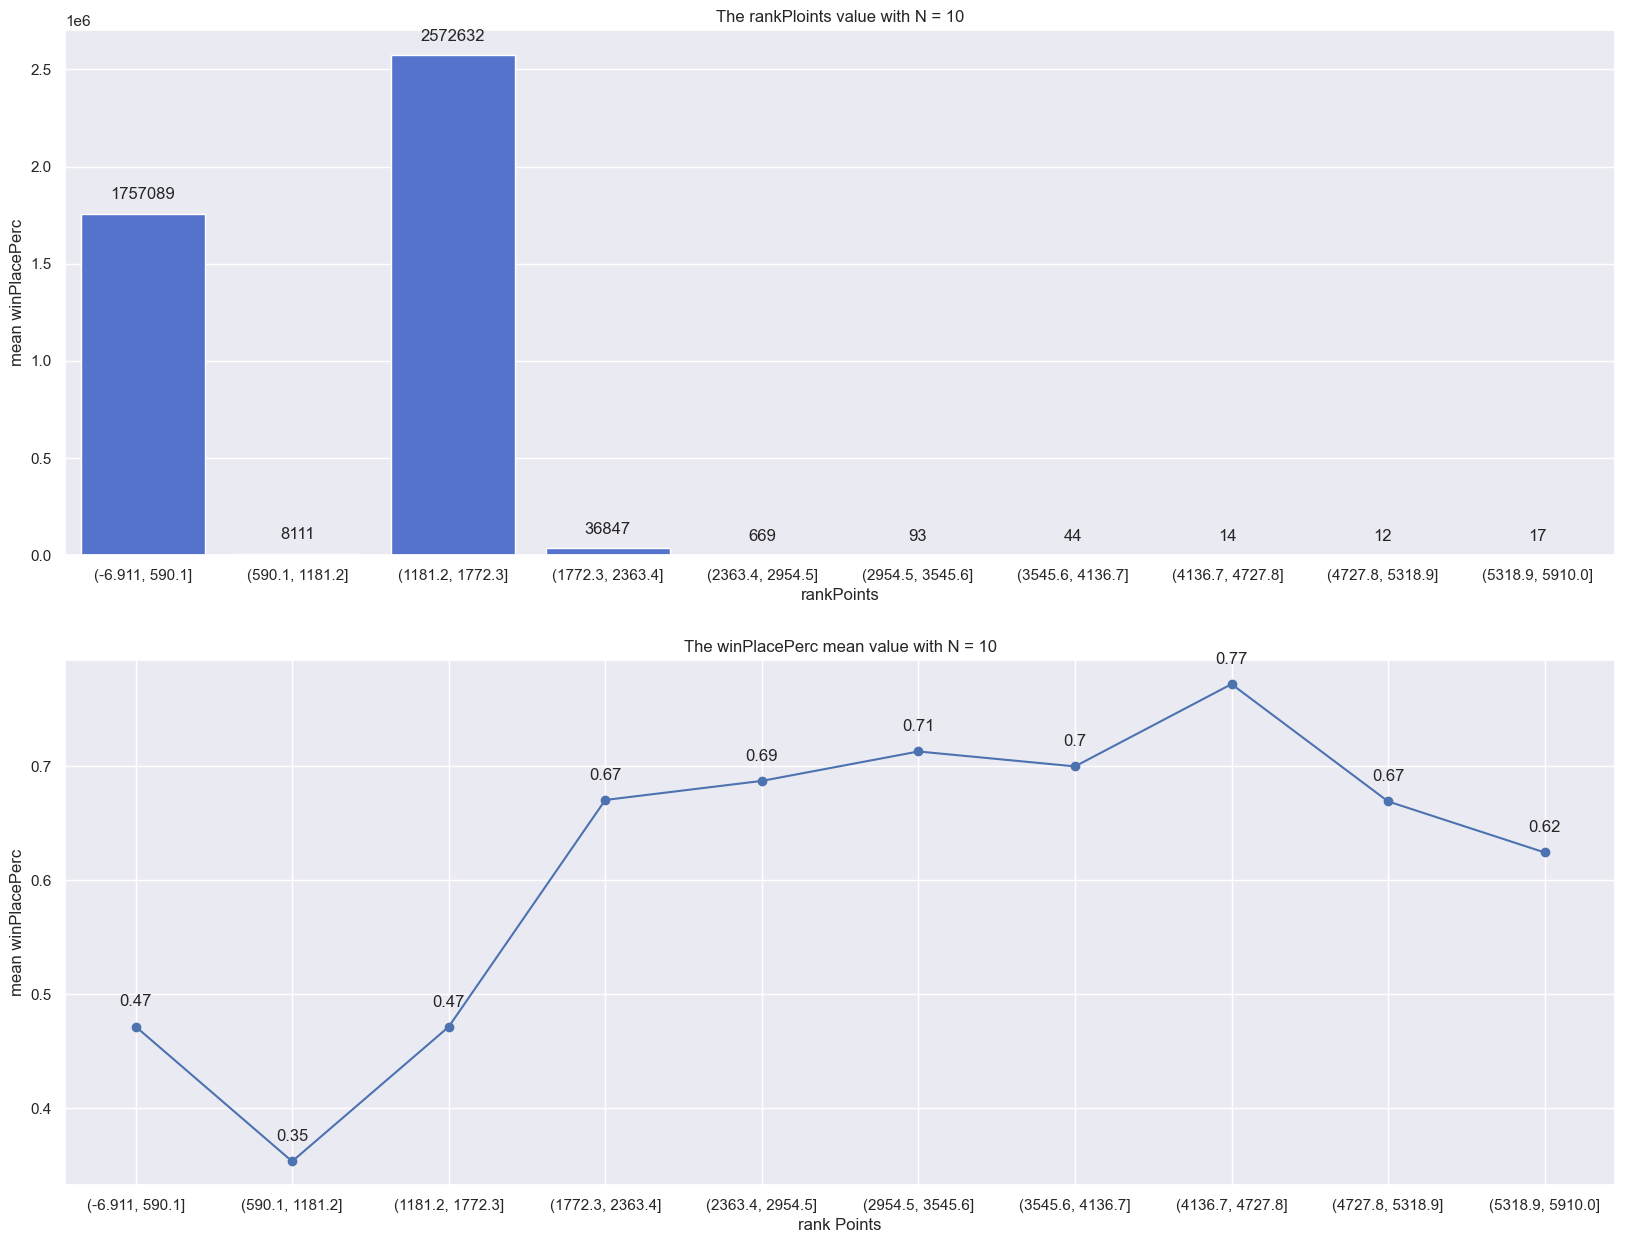

In [17]:
train2=train.copy()
# binning equal width
train2['rankPoints']=pd.cut(train2['rankPoints'], bins=10)
rankPoints_binning_10 = train2['rankPoints'].value_counts().sort_index()
winPlacePerc_binning=train2.groupby('rankPoints')['winPlacePerc'].mean()

# plot
plt.figure(figsize=(20,15))
plt.subplot(2,1,1)
sns.barplot(x=rankPoints_binning_10.index,y=rankPoints_binning_10.values,color='royalblue')
for i, v in enumerate(rankPoints_binning_10):
    plt.text(i, v + 60000, str(v), ha='center', va='bottom')
plt.ylabel("mean winPlacePerc")
plt.title("The rankPloints value with N = 10")

plt.subplot(2,1,2)
plt.plot(range(winPlacePerc_binning.count()),winPlacePerc_binning.values, marker='o', linestyle='-')
for i, v in enumerate(winPlacePerc_binning):
    plt.text(i, v+ 0.015, str(round(v,2)), ha='center', va='bottom')
plt.title("The winPlacePerc mean value with N = 10")
plt.xlabel("rank Points")
plt.ylabel("mean winPlacePerc")
plt.xticks(range(winPlacePerc_binning.count()),winPlacePerc_binning.index);

In general, the higher the rankPoints, the higher the winPlacePerc except in some places perhaps due to the number of participants in the match or other factors.

### 2.4 Which type of match is more popular?

In [18]:
# Which type of match is more popular?
train3=train.copy()
groupBy_matchType=train3.groupby('matchType')['matchId'].count()
data=groupBy_matchType.values*100/groupBy_matchType.sum()
# Compare the match duration of the match type ?
groupBy2=train3[train['rankPoints']>=0].groupby('matchType')['winPoints'].mean()

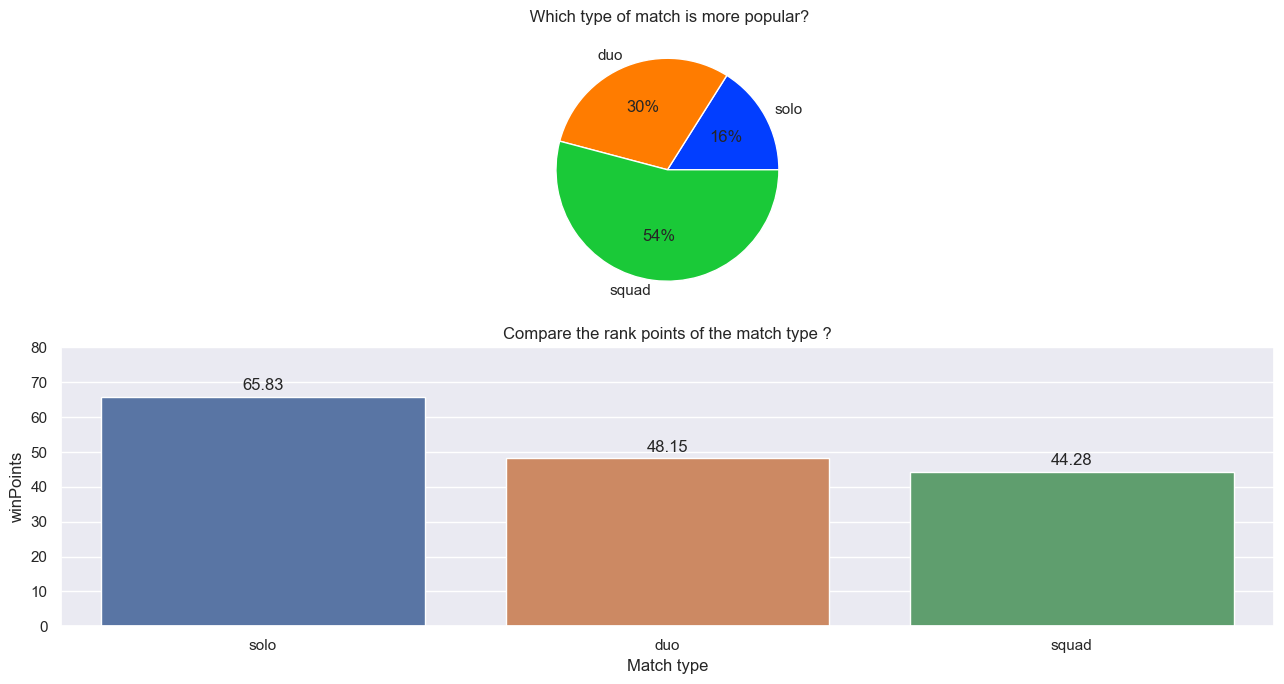

In [19]:
# Which type of match is more popular?
plt.figure(figsize=(13,7))
plt.subplot(2,1,1)
palette_color = sns.color_palette('bright')
plt.pie(data, labels=['solo','duo','squad'], colors=palette_color, autopct='%.0f%%')
plt.title(' Which type of match is more popular?')

# Compare the match duration of the match type ?
plt.subplot(2,1,2)
sns.barplot(x=['solo','duo','squad'],y=groupBy2.values)
plt.title('Compare the rank points of the match type ?')
plt.xlabel('Match type')
plt.ylabel('winPoints')
for i, v in enumerate(groupBy2):
    plt.text(i, v + 1, str(round(v,2)), ha='center', va='bottom')
    plt.ylim(0,80)
plt.tight_layout()

In general, highly skilled players will prefer to play solo, while squad is more popular because it has a high team spirit.

### 2.5 probability of being killed by headshot versus being killed while in a vehicle

In [20]:
train4=train.copy()

In [21]:
kills=train4['kills'].sum()
roadKillsRate=train4['roadKills'].sum()*100/kills
headshotsKills=train4['headshotKills'].sum()*100/kills

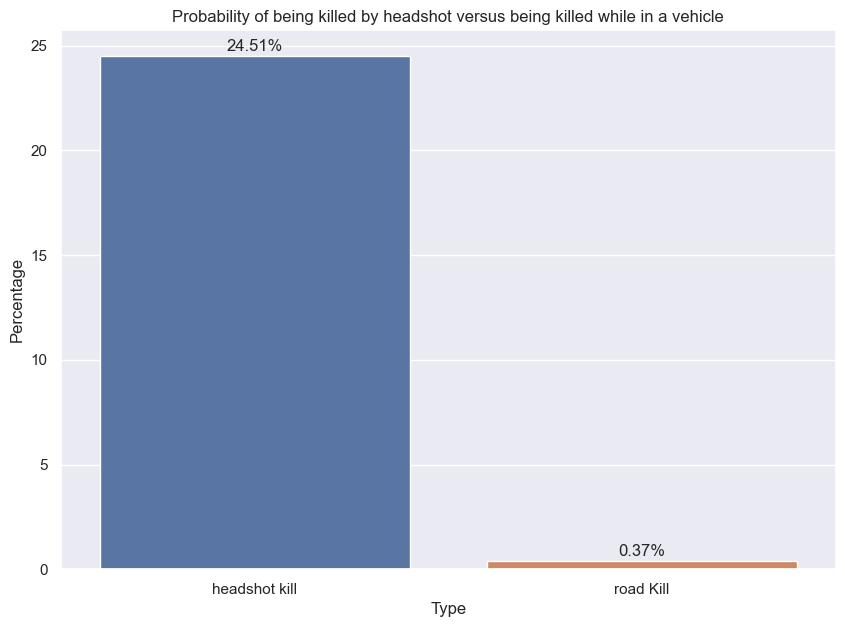

In [22]:
plt.figure(figsize=(10,7))
sns.barplot(x=['headshot kill','road Kill'],y=[headshotsKills,roadKillsRate])
plt.text(0, headshotsKills+0.1 , str(f'{round(headshotsKills,2)}%'), ha='center', va='bottom')
plt.text(1, roadKillsRate+0.1 , str(f'{round(roadKillsRate,2)}%'), ha='center', va='bottom')
plt.title('Probability of being killed by headshot versus being killed while in a vehicle')
plt.xlabel('Type')
plt.ylabel('Percentage');

Looking at the chart, we can see that for every 4 people killed, 1 person was shot in the head, and the number of people killed in the car was very small because the car was driving at high speed so it was difficult for the player to be shot.

### 2.6 Comparison between RideDistance, swimDistance and walkDistance

In [23]:
train5=train.copy()
walk=train5['walkDistance'].sum()
swim=train5['swimDistance'].sum()
ride=train5['rideDistance'].sum()

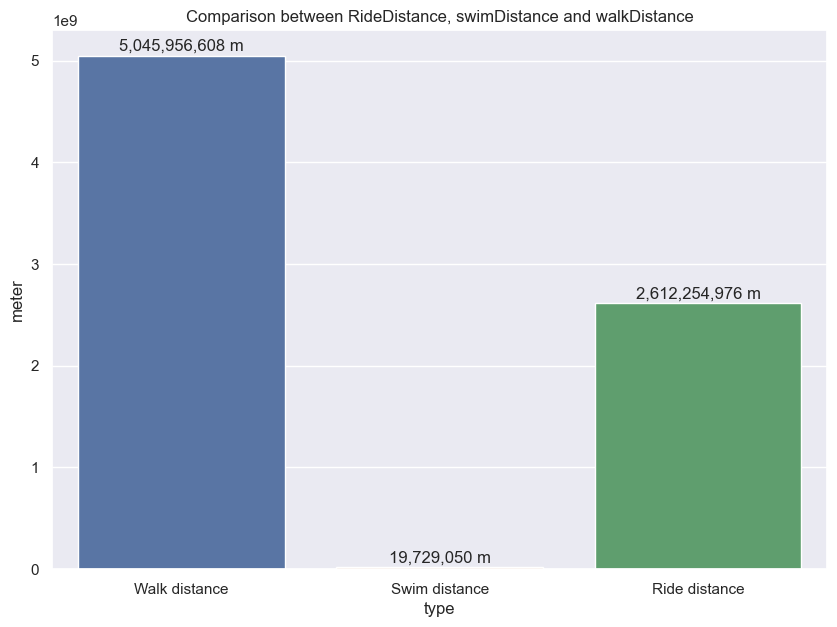

In [24]:
plt.figure(figsize=(10,7))
sns.barplot(x=['Walk distance','Swim distance','Ride distance'],y=[walk,swim,ride])
plt.title('Comparison between RideDistance, swimDistance and walkDistance')
plt.xlabel('type')
plt.ylabel('meter')

plt.text(0, walk + 20000000, str('{:,.0f} m'.format(walk)), ha='center', va='bottom')
plt.text(1, swim + 20000000, str('{:,.0f} m'.format(swim)), ha='center', va='bottom')
plt.text(2, ride + 20000000, str('{:,.0f} m'.format(ride)), ha='center', va='bottom');

Looking at the chart, we can see that players prefer to ride and walk rather than swim because swimming is very likely to be shot to death

# 3. Train

### 3.1 reduce data

Because there are some columns that are not important in training, I decided to drop those columns

In [25]:
X=train.drop(['matchId','groupId','winPlacePerc'],axis=1)
y=train['winPlacePerc']
X=np.array(X[:X.shape[0]].values,dtype=np.float32)
y=np.array(y.values).reshape(-1,1)
X_train,X_valid,y_train,y_valid=train_test_split(X,y,test_size=0.25,random_state=42)

### 3.2 Create multiple layer perceptron(MLP) model
Since the MLP model is a nonlinear model, I decided to test this model against the results of the linear regression model. Architecture of my MLP model
+ The input layer has 25 neurons
+ Hidden layer 1 has 64 neurons with activation function 'relu'
+ Hidden layer 2 has 32 neurons with activation function 'relu'
+ Output layer has 1 neurons to predict the player's winPlacePerc

In [26]:
def create_MLP_model():
    # define number of attributes
    n_features=X_train.shape[1]
    # count number of samples in each set of data
    n_trains=train.shape[0]
    # define amount of neurons

    n_layer_in=n_features
    n_layer_h1=64
    n_layer_h2=32
    n_layer_out=1

    MLP_model=tf.keras.Sequential()
    # input layer
    MLP_model.add(tf.keras.layers.Input(shape=(n_layer_in,)))
    # hidden 1 layer
    MLP_model.add(tf.keras.layers.Dense(n_layer_h1))
    MLP_model.add(tf.keras.layers.Activation('relu'))
    # hidden 2 layer
    MLP_model.add(tf.keras.layers.Dense(n_layer_h2))
    MLP_model.add(tf.keras.layers.Activation('relu'))
    # output layer
    MLP_model.add(tf.keras.layers.Dense(n_layer_out))
    # optimizers
    opt = tf.keras.optimizers.Adam(lr=0.001)
    # Let's train the MLP_model using RMSprop
    MLP_model.compile(loss='mean_squared_error',
                optimizer=opt,
                metrics=['accuracy'])
    MLP_model.summary()
    return MLP_model

### 3.3 Create lightGBM model

The hyperparameters for an LGBMRegressor model.
+ colsample_bytree:  Fraction of features to be randomly selected and used when building each tree. It helps prevent overfitting by introducing randomness into the model.
+ learning_rate:  This controls the step size at each iteration while moving toward a minimum of the loss function.
+ max_depth: Maximum depth of each tree.
+ min_split_gain: Minimum loss reduction required to make a further partition on a leaf node of the tree.
+ n_estimatorsn_estimators: The number of boosting rounds or trees to build.
+ num_leaves:  Maximum number of leaves for each tree.
+ reg_alpha: L1 and L2 regularization terms applied to the leaf weights. These terms help control overfitting by penalizing large weights.
+ subsample: Fraction of data to be randomly selected and used for training each tree. 
+ subsample_for_bin:  Number of data points to sample when creating histograms for finding the best splits.
+ n_jobs: The number of CPU cores to use during training. Setting it to -1 means using all available cores.
+ max_bin: Maximum number of discrete bins to bucket feature values in. This can affect the model's performance and memory usage.
+ num_iterations: The number of boosting iterations, which is set to 5100. This is similar to n_estimators but is used specifically for LightGBM.
+ min_data_in_bin: Minimum number of data points that should be in each bin.

In [27]:
def creat_lightGBM_model():
    model=LGBMRegressor(colsample_bytree=0.8, learning_rate=0.03, max_depth=30,
              min_split_gain=0.00015, n_estimators=250, num_leaves=2200,reg_alpha=0.1, reg_lambda=0.001, subsample=0.8,
              subsample_for_bin=45000, n_jobs =1, max_bin =700, num_iterations=5100, min_data_in_bin = 12)
    return model

## 3.4 Linear regression

Class Linear regression:
+ Task: to predict y from x by outputting y_pred = $h_w$(x) = $W^TX$
+ The train dataset $D_{train}$ denoted as (X,y) include N sample ${(x_1, y_1), (x_2, y_2), (x_3, y_3)...(x_n, y_n)}$, construct the matrix X and the vectors y and y_pred:
  - X.shape = (N, a) while a is number of features
  - y.shape = (N,)
  - $y_{pred}$ = (N,)
  - W.shape = (a,)
+ $MSE_{train} = \frac{1}{N} || y_pred-y ||^2 = \frac{1}{N}\sum_{n=1}^{N} (y_{pred-y})^2$
+ $∇_w(MSE_{Train}) = ∇_w(W^TX^TX_w - w^TX^Ty - y^TX_w + y^Ty) = 2X^TX_w - 2X^Ty$

$∇_w = 0$

$<=> 2X^TX_w - 2X^Ty = 0$

$<=> 2X^TX_w = 2X^Ty$

$<=> w = ((X^TX)^{-1}X^Ty)$

The ultimate goal is to find w from the above formula

In [28]:
class LinearRegression:
    def __init__(self) -> None:
        w = None
    def fit(self, X_train, y):
        bias_column = np.ones((X_train.shape[0], 1))
        X = np.concatenate((bias_column, X_train), axis=1) # add bias 
        inverse_matrix = np.linalg.inv(X.T@X) # (X^T*X)^-1
        self.w= inverse_matrix@(X.T@y) # calc w
    def predict(self,X_test):
        bias_column = np.ones((X_test.shape[0], 1))
        X=np.concatenate((bias_column, X_test), axis=1) # add bias 
        y_pred=X@self.w
        return y_pred
    

## 3.5 Random forest

In [29]:
from sklearn.tree import DecisionTreeRegressor

In [30]:
num_bagging = 100
num_samples= 40000
forest=[]
bagging_list=[]
for i in range(num_bagging):
    random_indeces=np.random.choice(len(X_train),num_samples)
    bagging_list.append(X_train[random_indeces])
    bagging_list.append(y_train[random_indeces])
for i in range(num_bagging):
    regressor = DecisionTreeRegressor(max_depth=None, min_samples_split=2, random_state=42)
    forest.append(regressor.fit(bagging_list[2*i],bagging_list[2*i+1]))


In [31]:
class RandomForest():
    def __init__(self,num_bagging,num_samples) -> None:
        self.num_bagging=num_bagging
        self.num_samples=num_samples
        self.forest=[]
        self.bagging_list=[]
    def fit(self,X_train,y_train):
        # boostrapping
        for i in range(self.num_bagging):
            random_indeces=np.random.choice(len(X_train),self.num_samples)
            self.bagging_list.append(X_train[random_indeces])
            self.bagging_list.append(y_train[random_indeces])
        # init forest
        for i in range(self.num_bagging):
            regressor = DecisionTreeRegressor(max_depth=None, min_samples_split=2, random_state=42)
            self.forest.append(regressor.fit(self.bagging_list[2*i],self.bagging_list[2*i+1]))
    def predict(self, X_test):
        arr=[]
        for i in range(self.num_bagging):
            arr.append(self.forest[i].predict(X_test))
        result_forest=np.array(arr)
        y_predict=np.mean(result_forest,axis=0)
        return y_predict

In [32]:
model=RandomForest(num_bagging=100,num_samples=60000)
model.fit(X_train,y_train)

### 3.6 Train model

In [33]:
num_model=5 # 0 is MLP, 1 is lightGBM, 2 is linear regression

if num_model==0:
    model=create_MLP_model()
    history = model.fit(X_train, y_train, epochs=2, batch_size=32, validation_data=(X_valid,y_valid))
elif num_model==1:
    model=creat_lightGBM_model()
    model.fit(X_train,y_train, eval_set=[(X_valid, y_valid)],callbacks=[early_stopping(5),log_evaluation(period=1, show_stdv=True)])
elif num_model==2:
    model=LinearRegression()
    model.fit(X_train,y_train)
elif num_model==3:
    model=RandomForest(num_bagging=100,num_samples=60000)
    model.fit(X_train,y_train)

# 4. Test

### 4.1 Reformatting of test data

In [34]:
test.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints
0,9329eb41e215eb,676b23c24e70d6,45b576ab7daa7f,0,0,51.46,0,0,0,73,...,1500,0,0.0,0,0.0,0,0,588.0,1,0
1,639bd0dcd7bda8,430933124148dd,42a9a0b906c928,0,4,179.10,0,0,2,11,...,1503,2,4669.0,0,0.0,0,0,2017.0,6,0
2,63d5c8ef8dfe91,0b45f5db20ba99,87e7e4477a048e,1,0,23.40,0,0,4,49,...,1565,0,0.0,0,0.0,0,0,787.8,4,0
3,cf5b81422591d1,b7497dbdc77f4a,1b9a94f1af67f1,0,0,65.52,0,0,0,54,...,1465,0,0.0,0,0.0,0,0,1812.0,3,0
4,ee6a295187ba21,6604ce20a1d230,40754a93016066,0,4,330.20,1,2,1,7,...,1480,1,0.0,0,0.0,0,0,2963.0,4,0


In [35]:
test1=test.copy()
test1=test1.dropna()
test1.drop('Id',axis=1,inplace=True)
test1['matchType']=test1['matchType'].apply(lambda x: 1 if ('solo' in x) else 2 if ('duo' in x) or ('crash' in x) else 4 )
for col in test1:
    if test1[col].dtype=='float64':
        test1[col]= pd.to_numeric(test1[col], downcast= 'float')
    if test1[col].dtype=='int64':
        test1[col]= pd.to_numeric(test1[col], downcast= 'integer')
X_test1=test1.drop(['matchId','groupId'],axis=1).values

In [36]:
y_pred=model.predict(X_test1)

In [37]:
# format submition
test_id=test['Id']
result=pd.DataFrame({'Id':test_id,'winPlacePerc':y_pred.squeeze()})

In [38]:
result['winPlacePerc']=np.where(result['winPlacePerc']>1,1,result['winPlacePerc'])
result['winPlacePerc']=np.where(result['winPlacePerc']<0,0,result['winPlacePerc'])

In [39]:
result.to_csv("submission.csv", index=False)